In [3]:
from langchain_openai import ChatOpenAI
from langchain_pinecone import PineconeVectorStore
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from src.helper import download_hugging_face_embeddings
from dotenv import load_dotenv
import os
from src.prompt import *
load_dotenv()

PINECONE_API_KEY = os.environ.get('PINECONE_API_KEY')
OPENAI_AGENT_API_KEY = os.environ.get('OPENAI_AGENT_API_KEY')

embeddings = download_hugging_face_embeddings()
os.environ["OPENAI_AGENT_API_KEY"] = OPENAI_AGENT_API_KEY
llm = ChatOpenAI(temperature=0, model="gpt-4.1-mini", openai_api_key=OPENAI_AGENT_API_KEY)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)
embeddings = download_hugging_face_embeddings()
index_name = "medicalbot"
# index_name = "darrenchenhw"

# Embed each chunk and upsert the embeddings into your Pinecone index.
docsearch = PineconeVectorStore.from_existing_index(
    index_name=index_name,
    embedding=embeddings
)

retriever = docsearch.as_retriever(search_type="similarity", search_kwargs={"k": 3})

question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)



# Retriever Tool

## Retriever Tool Test

In [4]:
from langchain.tools import tool
from pydantic import BaseModel

class RagToolSchema(BaseModel):
    question: str

@tool(args_schema=RagToolSchema)
def retriever_tool(question):
    """Tool to Retrieve Semantically Similar documents to answer User Questions related to Stroke"""

    print("INSIDE RETRIEVER NODE")
    docsearch = PineconeVectorStore.from_existing_index(
    index_name=index_name,
    embedding=embeddings
)

    retriever = docsearch.as_retriever(search_type="similarity", search_kwargs={"k": 3})

    question_answer_chain = create_stuff_documents_chain(llm, prompt)
    rag_chain = create_retrieval_chain(retriever, question_answer_chain)
    response = rag_chain.invoke({"input": question})
    answer = response.get("answer")  # Safely retrieve the 'answer' from the response

    return answer

In [5]:

# question = "What is stroke?"
# docsearch = PineconeVectorStore.from_existing_index(
# index_name=index_name,
# embedding=embeddings
# )

# retriever = docsearch.as_retriever(search_type="similarity", search_kwargs={"k": 3})  
# question_answer_chain = create_stuff_documents_chain(llm, prompt)
# rag_chain = create_retrieval_chain(retriever, question_answer_chain)
# response = rag_chain.invoke({"input": question})
# print(response["answer"])

# Deep Learning Model Tool

In [23]:
import pandas as pd
vitals_data = "/Users/zfeng/Documents/fyp-github/FIT3199-FYP/patient_data/vitals_data.csv"
pd.read_csv(vitals_data)

,heartrate,resprate,o2sat,sbp,dbp,stroke,length,start,subject_id,admission_id,prediction_score,res
0,66.1,16.6,97.6,130.1,70.4,0,1000,0,10001112,50001494,"[0.18727005942368125, 0.4753571532049581, 0.36...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,70.8,16.5,93.2,102.8,70.5,0,1000,1000,10002574,50004131,"[0.4609371175115584, 0.8802200578860938, 0.097...","[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,71.6,14.5,95.6,98.6,70.0,0,1000,2000,10001901,50002077,"[0.08061064362700221, 0.46484882617128653, 0.4...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, ..."
3,79.8,14.9,97.2,108.5,78.0,0,1000,3000,10002881,50004126,"[0.04514488502720415, 0.417651247794619, 0.160...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
4,70.2,17.9,97.6,113.6,66.8,0,1000,4000,10003194,50002703,"[0.2469468575917173, 0.0894113546106644, 0.183...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96.1,20.0,87.8,167.9,90.8,1,1000,95000,10003861,50001418,"[0.06517656502163277, 0.1017674369434482, 0.38...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
96,57.3,16.7,96.5,129.5,73.0,0,1000,96000,10004375,50000092,"[0.029228993618438504, 0.14996469873653312, 0....","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ..."
97,85.4,12.3,96.3,120.2,88.4,0,1000,97000,10003154,50002185,"[0.22836529644292014, 0.9836136352964666, 0.02...","[0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
98,73.1,17.6,98.8,121.0,67.9,0,1000,98000,10001178,50001539,"[0.45479769555547217, 0.0030919113204483373, 0...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [30]:
vitals_data = pd.read_csv(vitals_data)

In [32]:
vitals_data.dtypes

heartrate           float64
resprate            float64
o2sat               float64
sbp                 float64
dbp                 float64
stroke                int64
length                int64
start                 int64
subject_id            int64
admission_id          int64
prediction_score     object
res                  object
dtype: object

In [50]:
from typing import List
from pydantic import BaseModel
from langchain.tools import tool

# ICD code dictionary provided
icd_code_dict = {
    "I481": "Persistent atrial fibrillation",
    "I4891": "Atrial fibrillation, unspecified",
    "I110": "Hypertensive heart disease with heart failure",
    "I120": "Hypertensive chronic kidney disease with stage 5 chronic kidney disease or end stage renal disease",
    "I132": "Hypertensive heart and chronic kidney disease with heart failure and with stage 5 CKD or ESRD",
    "I210": "ST elevation (STEMI) myocardial infarction of anterior wall",
    "I200": "Unstable angina",
    "I255": "Ischemic cardiomyopathy",
    "I7025": "Atherosclerosis of native arteries of other extremities with ulceration",
    "I447": "Left bundle-branch block, unspecified",
    "I451": "Other and unspecified right bundle-branch block",
    "I440": "First degree atrioventricular block",
    "R000": "Tachycardia, unspecified",
    "R001": "Bradycardia, unspecified",
    "I5043": "Acute on chronic combined systolic and diastolic heart failure",
    "I081": "Rheumatic disorders of both mitral and tricuspid valves",
    "I340": "Nonrheumatic mitral (valve) insufficiency",
    "I359": "Nonrheumatic aortic valve disorder, unspecified",
    "I078": "Other rheumatic tricuspid valve diseases",
    "I428": "Other cardiomyopathies",
    "E1129": "Type 2 diabetes mellitus with other diabetic kidney complication",
    "E103": "Type 1 diabetes mellitus with ophthalmic complications",
    "E660": "Obesity due to excess calories",
    "N186": "End stage renal disease",
    "D631": "Anemia in chronic kidney disease",
    "D65": "Disseminated intravascular coagulation [defibrination syndrome]",
    "C925": "Acute myelomonocytic leukemia",
    "A40": "Streptococcal sepsis",
    "A419": "Sepsis, unspecified organism",
    "R570": "Cardiogenic shock"
}

# Tool input schema
class RagToolSchema(BaseModel):
    question: str  # Expected to be of the form: "subject_id:..., admission_id:..."

# Main retrieval tool
@tool(args_schema=RagToolSchema)
def ecg_analyzer(question):
    """Tool to give ECG disease prediction based on subject_id and admission_id and further prevention tips"""

    import pandas as pd
    import ast
    vitals_path = "/Users/zfeng/Documents/fyp-github/FIT3199-FYP/patient_data/vitals_data.csv"
    vitals_data = pd.read_csv(vitals_path)
    vitals_data["prediction_score"] = vitals_data["prediction_score"].apply(ast.literal_eval)
    vitals_data["res"] = vitals_data["res"].apply(ast.literal_eval)
    # Extract subject_id and admission_id from question
    try:
        parts = question.replace(" ", "").split(",")
        subject_id = int(parts[0].split(":")[1])
        admission_id = int(parts[1].split(":")[1])
    except Exception:
        return "Please format your question as 'subject_id:XXXX, admission_id:XXXX'."

    # Filter vitals_data to get the row
    row = vitals_data[(vitals_data['subject_id'] == subject_id) & 
                      (vitals_data['admission_id'] == admission_id)]
    
    if row.empty:
        return f"No data found for subject_id: {subject_id} and admission_id: {admission_id}."

    pred_scores = row.iloc[0]['prediction_score']
    icd_codes = list(icd_code_dict.keys())

    # Pair ICD codes with their prediction scores
    score_pairs = list(zip(icd_codes, pred_scores))
    score_pairs.sort(key=lambda x: x[1], reverse=True)

    top5 = score_pairs[:5]
    top5_str = "\n".join([f"- {code}: {icd_code_dict[code]} (Score: {float(score):.2f})" for code, score in top5])

    full_ranking = "\n".join([f"{code}: {float(score):.2f}" for code, score in score_pairs])

    prevention_tips = (
        "\n\n**Stroke Prevention Tips:**\n"
        "- Manage blood pressure and cholesterol levels\n"
        "- Control diabetes and heart-related issues\n"
        "- Avoid smoking and reduce alcohol intake\n"
        "- Maintain a healthy weight and exercise regularly\n"
        "- Follow up with cardiac and renal health screening"
    )

    return (
        f"🔍 The ECG data of subject ID `{subject_id}` and admission ID `{admission_id}` "
        f"shows most relevance to the following diseases:\n\n{top5_str}\n\n"
        f"📊 This is the ranked prediction result of our model:\n\n{full_ranking}"
        f"{prevention_tips}"
    )


In [51]:
question = "Give the ecg predcition of diseases for subject_id:10001112, admission_id:50001494"
result = ecg_analyzer.invoke({"question": question})
print(f"Answer: {result}")

Answer: 🔍 The ECG data of subject ID `10001112` and admission ID `50001494` shows most relevance to the following diseases:

- N186: End stage renal disease (Score: 0.99)
- I132: Hypertensive heart and chronic kidney disease with heart failure and with stage 5 CKD or ESRD (Score: 0.97)
- E103: Type 1 diabetes mellitus with ophthalmic complications (Score: 0.95)
- I081: Rheumatic disorders of both mitral and tricuspid valves (Score: 0.89)
- I447: Left bundle-branch block, unspecified (Score: 0.80)

📊 This is the ranked prediction result of our model:

N186: 0.99
I132: 0.97
E103: 0.95
I081: 0.89
I447: 0.80
I440: 0.48
I4891: 0.48
I255: 0.43
R000: 0.42
D65: 0.39
I110: 0.37
E1129: 0.31
I7025: 0.30
I120: 0.30
A419: 0.30
I359: 0.26
A40: 0.26
D631: 0.23
I078: 0.22
I481: 0.19
I340: 0.15
E660: 0.15
I428: 0.15
R001: 0.11
C925: 0.10
I5043: 0.09
I210: 0.08
I200: 0.03
R570: 0.02
I451: 0.01

**Stroke Prevention Tips:**
- Manage blood pressure and cholesterol levels
- Control diabetes and heart-relate

# ECG Visualizer

In [ ]:
# from langchain.tools import tool
# import numpy as np
# import matplotlib.pyplot as plt
# import io
# import base64
# import pandas as pd
# from pydantic import BaseModel

# class ECGToolSchema(BaseModel):
#     subject_id: str
#     admission_id: str

# @tool(args_schema=ECGToolSchema)
# def visualize_ecg(subject_id: str, admission_id: str):
#     """Tool to visualize the 12-lead ECG for a specific patient based on subject and admission ID."""
#     print("✅ visualize_ecg invoked!")

#     # Load the memmap ECG data
#     memmap_path = "/Users/zfeng/Documents/fyp-github/FIT3199-FYP/patient_data/memmap.npy"
#     ecg_data = np.memmap(memmap_path, dtype=np.float32, mode='r')
#     ecg_data = ecg_data.reshape((-1, 12))  # assuming 12-lead

#     # Load vital data with subject_id, admission_id, start, length
#     vital_data_path = "/Users/zfeng/Documents/fyp-github/FIT3199-FYP/patient_data/vital_data.csv"
#     vital_df = pd.read_csv(vital_data_path)

#     # Filter the row for the given subject and admission ID
#     patient_row = vital_df[
#         (vital_df["subject_id"] == subject_id) &
#         (vital_df["admission_id"] == admission_id)
#     ]

#     if patient_row.empty:
#         return f"No data found for subject_id={subject_id} and admission_id={admission_id}"

#     start_idx = int(patient_row["start"].values[0])
#     length = int(patient_row["length"].values[0])
#     patient_index = patient_row.index[0]

#     # Extract the ECG signal for this patient
#     patient_data = ecg_data[start_idx:start_idx + length, :]

#     # ECG lead names
#     lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

#     # Create a figure with 12 subplots
#     fig, axes = plt.subplots(3, 4, figsize=(15, 10))
#     axes = axes.flatten()

#     for i, ax in enumerate(axes):
#         if i < 12:
#             ax.plot(patient_data[:, i])
#             ax.set_title(f'Lead {lead_names[i]}')
#             ax.grid(True, alpha=0.3)
#             ax.set_xticks([])
#             ax.set_yticks([])

#             # Add a scale bar
#             y_range = np.max(patient_data[:, i]) - np.min(patient_data[:, i])
#             scale_bar = y_range * 0.2
#             ax.plot([10, 10], [np.min(patient_data[:, i]), np.min(patient_data[:, i]) + scale_bar],
#                     'k-', linewidth=2)
#         else:
#             ax.axis('off')

#     plt.suptitle(f'12-Lead ECG - Subject {subject_id}, Admission {admission_id}', fontsize=16)
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.92)

#     # Save to buffer
#     img = io.BytesIO()
#     plt.savefig(img, format='png', dpi=300, bbox_inches='tight')
#     img.seek(0)
#     plt.close()

#     # Convert to base64
#     img_base64 = base64.b64encode(img.read()).decode("utf-8")
#     img_data_uri = f"data:image/png;base64,{img_base64}"

#     # Explanation
#     explanation = f"This ECG plot shows the 12-lead ECG for subject ID {subject_id} during admission {admission_id}. The leads follow the standard clinical configuration."

#     return f"{img_data_uri}\n\n{explanation}"


## ECG Visualizer Tool Test

In [ ]:
# question = "Visualize the 12-lead ECG for patient 0"
# result = visualize_ecg.invoke({"question": question})
# print(f"Answer: {result}")


In [8]:
tools = [retriever_tool, visualize_ecg]
llm_with_tools = llm.bind_tools(tools)

# Combined

In [9]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]


In [52]:
from langgraph.prebuilt import ToolNode, tools_condition


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[retriever_tool, ecg_analyzer])
graph_builder.add_node("tools", tool_node)

In [53]:
from langgraph.prebuilt import tools_condition

graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")


In [12]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

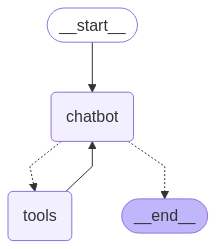

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
# config = {"configurable": {"thread_id": "1"}}

# while True:
#     user_input = input("User: ")
#     if user_input.lower() in ["quit", "exit", "q"]:
#         print("Goodbye!")
#         break

#     for event in graph.stream({"messages": [("user", user_input)]}, config):
#         for value in event.values():
#             print("Assistant:", value["messages"][-1].content)


✅ visualize_ecg invoked!


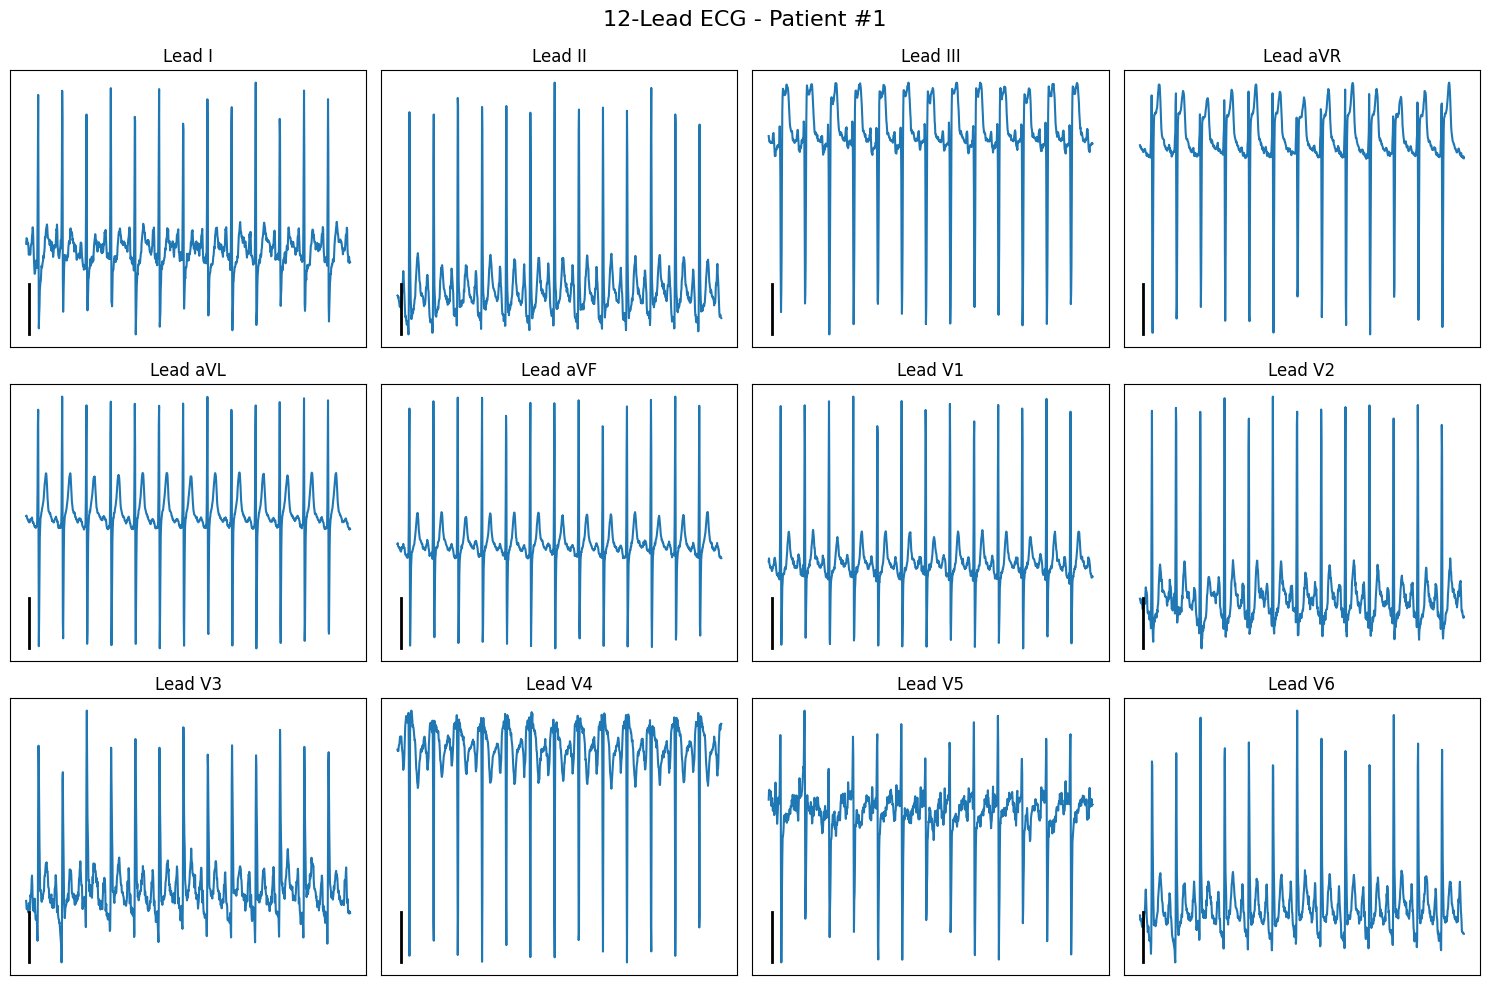

Assistant: Here is the 12-lead ECG visualization for patient 0. The leads are labeled from I to V6, and the vertical scale bar represents approximately 1 mV. This ECG data is displayed in a standard clinical format for interpretation. If you need any specific analysis or details about this ECG, please let me know!


In [20]:
graph_input = {"messages": [("user", "Visualize the 12-lead ECG for patient 0")]}
config = {"configurable": {"thread_id": "1"}}

response = graph.invoke(graph_input, config=config)
content = response["messages"][-1].content
print("Assistant:", content)